# Train a Deep NN to predict Asset Price movements

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

The GridSearchCV class provided by scikit-learn that we encountered in Chapter 6, The Machine Learning Workflow conveniently automates this process. Just be mindful of the risk of false discoveries and keep track of how many experiments you are running to adjust the results accordingly.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price moves for a one-month horizon.

## Setup Docker for GPU acceleration

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/16_convolutions_neural_nets/cnn:/cnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import os
from pathlib import Path
from importlib import reload
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from keras.models import Sequential
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from keras.callbacks import Callback, EarlyStopping, TensorBoard, ModelCheckpoint

In [2]:
np.random.seed(42)

## Create a stock return series to predict asset price moves

We will use the last 24 monthly returns and dummy variables for the month and the year to predict whether the price will go up or down the following month. We use the daily Quandl stock price dataset (see GitHub for instructions on how to source the data).

In [3]:
prices = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack().loc['2007':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2896 entries, 2007-01-01 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 70.7 MB


We will work with monthly returns to keep the size of the dataset manageable and remove some of the noise contained in daily returns, which leaves us with almost 2,500 stocks with 120 monthly returns each:

In [4]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .loc['2008': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2017-12-31 to 2008-01-31
Freq: -1M
Columns: 2489 entries, A to ZUMZ
dtypes: float64(2489)
memory usage: 2.3 MB


In [5]:
returns.head().append(returns.tail())

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,ZEUS,ZIGO,ZINC,ZION,ZIOP,ZIXI,ZLC,ZMH,ZQK,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,-0.032785,0.030501,0.056469,0.006859,-0.012970,-0.015246,0.015584,0.016003,0.082528,-0.028226,...,0.078815,0.000000,0.000000,0.025832,-0.094092,-0.004545,0.000000,0.000000,0.000000,-0.044725
2017-11-30,0.017786,0.078385,0.025000,0.041429,0.235625,0.016623,-0.058680,0.007025,0.107587,0.035491,...,0.055085,0.000000,0.000000,0.066509,-0.019313,-0.092784,0.000000,0.000000,0.000000,0.235127
2017-10-31,0.061814,-0.014108,-0.156544,0.015228,-0.176008,0.096808,-0.067629,0.083987,-0.070091,-0.001043,...,-0.141818,0.000000,0.000000,-0.015261,-0.241042,-0.008180,0.000000,0.000000,0.000000,-0.024862
2017-09-30,-0.008035,0.061466,-0.013832,0.057515,0.013928,-0.060244,-0.014970,-0.033968,0.031153,0.090808,...,0.205479,0.000000,0.000000,0.080623,-0.039124,-0.079096,0.000000,0.000000,0.000000,0.453815
2017-08-31,0.082455,-0.111179,-0.043431,-0.035503,-0.125971,0.106251,0.124579,-0.013579,-0.140733,-0.038210,...,0.069057,0.000000,0.000000,-0.034067,0.155515,-0.003752,0.000000,0.000000,0.000000,-0.019685
2008-05-31,0.237670,-0.538999,-0.122768,0.162611,0.162053,0.085082,0.020105,0.153454,0.021099,-0.073431,...,0.269937,0.026587,0.002140,-0.062060,-0.163399,-0.321053,0.051158,-0.018339,-0.122302,0.000477
2008-04-30,0.012739,-0.035915,0.178947,-0.097354,0.018502,0.212195,0.103273,0.099698,-0.010493,-0.067248,...,0.135255,-0.062701,0.210708,0.017563,0.040816,-0.018088,0.048583,-0.047521,-0.008155,0.335245
2008-03-31,-0.025482,-0.281452,0.041991,0.213204,0.017068,0.147816,0.086957,-0.204873,-0.017737,0.139290,...,0.092010,-0.023548,-0.262420,-0.046073,-0.048544,-0.012755,0.022774,0.034135,0.090000,-0.107509
2008-02-29,-0.095983,-0.104046,0.067251,-0.072472,-0.062605,-0.076389,0.013216,-0.104762,-0.102822,-0.098859,...,0.223413,0.086104,0.047365,-0.120684,-0.063636,0.101124,0.180929,-0.036473,-0.055614,-0.085803


In [6]:
n = len(returns)
T = 24
tcols = list(range(25))

In [7]:
data = pd.DataFrame()
for i in range(n-T-1):
    df = returns.iloc[i:i+T+1]
    data = pd.concat([data, (df.reset_index(drop=True).T
                             .assign(year=df.index[0].year,
                                     month=df.index[0].month))],
                     ignore_index=True)
data[tcols] = (data[tcols].apply(lambda x: x.clip(lower=x.quantile(.01),
                                                  upper=x.quantile(.99))))
data['label'] = (data[0] > 0).astype(int)
data['date'] = pd.to_datetime(data.assign(day=1)[['year', 'month', 'day']])
data = pd.get_dummies((data.drop(0, axis=1)
                       .set_index('date')
                       .apply(pd.to_numeric)), 
                      columns=['year', 'month']).sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236455 entries, 2010-02-01 to 2017-12-01
Data columns (total 45 columns):
1            236455 non-null float64
2            236455 non-null float64
3            236455 non-null float64
4            236455 non-null float64
5            236455 non-null float64
6            236455 non-null float64
7            236455 non-null float64
8            236455 non-null float64
9            236455 non-null float64
10           236455 non-null float64
11           236455 non-null float64
12           236455 non-null float64
13           236455 non-null float64
14           236455 non-null float64
15           236455 non-null float64
16           236455 non-null float64
17           236455 non-null float64
18           236455 non-null float64
19           236455 non-null float64
20           236455 non-null float64
21           236455 non-null float64
22           236455 non-null float64
23           236455 non-null float64
24           236455 no

In [8]:
data.to_hdf('data.h5', 'returns')

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/pandas/io/pytables.py:274: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)


In [9]:
data.shape

(236455, 45)

In [12]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                            .get_level_values('date')
                            .unique()
                            .sort_values(ascending=False)[:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Define Network Architecture

### Custom AUC Loss Metric

For binary classification, AUC is an excellent metric because it assesses performance irrespective of the threshold chosen to convert probabilities into positive predictions. Unfortunately, Keras does not provide it ‘out-of-the-box’ because it focuses on metrics that help gradient descent optimized based on batches of samples during training. However, we can define a custom loss metric for use with the early stopping callback as follows (included in the compile step):

In [20]:
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

### Set up `build_fn` for `keras.wrappers.scikit_learn.KerasClassifier`

Keras contains a wrapper that we can use with the sklearn GridSearchCV class. It requires a build_fn that constructs and compiles the model based on arguments that can later be passed during the GridSearchCV iterations.

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [78]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=input_dim))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['binary_accuracy', auc_roc])

    return model

## Run Keras with `GridSearchCV`

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [9]:
data = pd.read_hdf('data.h5', 'returns')

In [6]:
X_train = data[:'2016'].drop('label', axis=1)
y_train = data[:'2016'].label

In [7]:
X_test = data['2017':].drop('label', axis=1)
y_test = data['2017':].label

### Define GridSearch inputs

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):

In [ ]:
input_dim = X_train.shape[1]

In [62]:
clf = KerasClassifier(make_model, epochs=10, batch_size=32)

In [13]:
n_splits = 12

In [14]:
cv = OneStepTimeSeriesSplit(n_splits=n_splits)

In [60]:
param_grid = {'dense_layers': [[32], [32, 32], [64], [64, 64], [64, 64, 32], [64, 32], [128]],
              'activation'  : ['relu', 'tanh'],
              'dropout'     : [.25, .5, .75],
              }

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [64]:
gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=cv,
                  refit=True,
                  return_train_score=True,
                  n_jobs=-1,
                  verbose=1,
                  iid=False,
                  error_score=np.nan)

In [ ]:
fit_params = dict(callbacks=[EarlyStopping(monitor='auc_roc', 
                                           patience=300, 
                                           verbose=1, mode='max')],
                  verbose=2,
                  epochs=50)

In [ ]:
gs.fit(X=X_train.astype(float), y=y_train, **fit_params)
print('\nBest Score: {:.2%}'.format(gs.best_score_))
print('Best Params:\n', pd.Series(gs.best_params_))

### Persist best model and training data

In [ ]:
gs.best_estimator_.model.save('best_model.h5')

In [ ]:
pd.DataFrame(gs.cv_results_).to_csv('cv_results.csv', index=False)

In [ ]:
y_pred = gs.best_estimator_.model.predict(test_data.drop('label', axis=1))
roc_auc_score(y_true=test_data.label, y_score=y_pred)

In [9]:
with pd.HDFStore('data.h5') as store:
    store.put('X_train', X_train)
    store.put('X_test', X_test)
    store.put('y_train', y_train)
    store.put('y_test', y_test)

In [94]:
cv_results = pd.read_csv('gridsearch/cv_results.csv')
cv_results = (cv_results.filter(like='param_')
              .join(cv_results
                    .filter(like='_test_score')
                    .filter(like='split'))
             .rename(columns = lambda x: x.replace('param_', '')))
cv_results =pd.melt(id_vars=['activation', 'dense_layers', 'dropout'], 
                    frame=cv_results,
                   value_name='score',
                   var_name='split')
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
activation      504 non-null object
dense_layers    504 non-null object
dropout         504 non-null float64
split           504 non-null object
score           504 non-null float64
dtypes: float64(2), object(3)
memory usage: 19.8+ KB


The following chart shows the range of cross-validation results for the various elements of the Neural Network architectures that we tested in our experiment. It shows that the settings that performed best in combination, when evaluated individually, tended to do as good as or better than the alternatives.

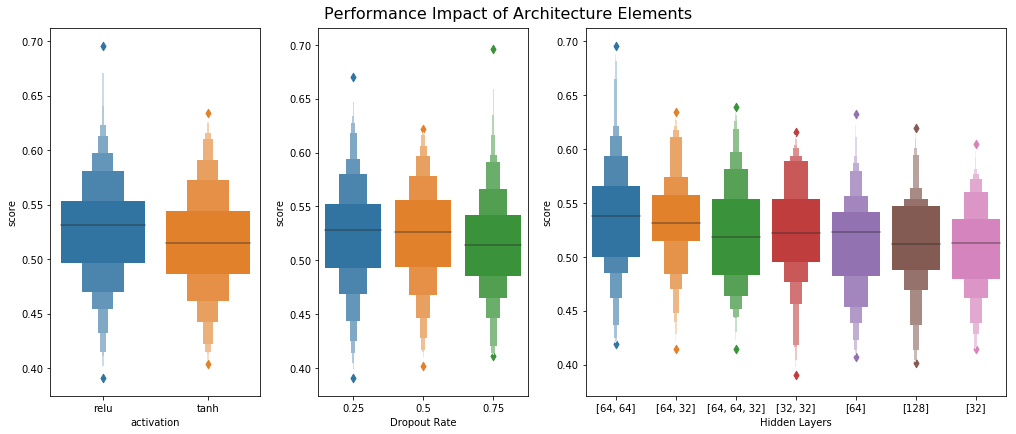

In [119]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
gs = GridSpec(nrows=1, ncols=4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel('Activation Functon')
sns.boxenplot(x='activation', y='score', data=cv_results, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
sns.boxenplot(x='dropout', y='score', data=cv_results, ax=ax2);
ax2.set_xlabel('Dropout Rate')
ax3 = fig.add_subplot(gs[0, 2:])
sns.boxenplot(x='dense_layers', y='score', data=cv_results, ax=ax3)
ax3.set_xlabel('Hidden Layers')
fig.suptitle('Performance Impact of Architecture Elements', fontsize=16)
fig.savefig('parameter_impact', dpi=300);

## Load best model

In [8]:
model = load_model('gridsearch/best_model.h5', custom_objects={'auc_roc': auc_roc})

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2880      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

### Predict 1 year of price moves

In [ ]:
y_pred = model.predict(test_data.drop('label', axis=1))

In [11]:
roc_auc_score(y_score=y_pred, y_true=test_data.label)

0.5106585850411519

## Retrain with all data

### Custom ROC AUC Callback

In [7]:
class auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(y_true=self.y, y_score=y_pred)
        y_pred_val = self.model.predict_proba(self.x_val)
        roc_val = roc_auc_score(y_true=self.y_val, y_score=y_pred_val)
        print('\rroc-auc: {:.2%} - roc-auc_val: {:.2%}'.format(roc, roc_val),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### Early Stopping

In [18]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=0,
                               mode='auto',
                               baseline=None,
                               restore_best_weights=False)

### Model Checkpoints

In [19]:
checkpointer = ModelCheckpoint('models/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True,
                               save_weights_only=False,
                               mode='auto',
                               period=1)

### Tensorboard

In [20]:
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=1,
                          batch_size=32,
                          write_graph=True,
                          write_grads=True,
                          update_freq='epoch')

In [10]:
data = pd.read_hdf('data.h5', 'returns')
features = data.drop('label', axis=1)
label = data.label

### Run cross-validation

In [31]:
for fold, (train_idx, test_idx) in enumerate(cv.split(data)):
    checkpointer = ModelCheckpoint('models/weights.{}.hdf5'.format(fold),
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True,
                               save_weights_only=False,
                               mode='auto',
                               period=1)
    tensorboard = TensorBoard(log_dir='./logs/{}'.format(fold),
                          histogram_freq=1,
                          batch_size=32,
                          write_graph=True,
                          write_grads=True,
                          update_freq='epoch')
    X_train = features.iloc[train_idx]
    X_test = features.iloc[test_idx]
    y_train = label.iloc[train_idx]
    y_test = label.iloc[test_idx]

    training = model.fit(X_train, 
                         y_train, 
                          batch_size=32, 
                          epochs=50, 
                          verbose=1, 
                          validation_data=(X_test, y_test), 
                          callbacks=[checkpointer, 
                                     tensorboard,
                                     early_stopping,
                                     auc_callback(training_data=(X_train, y_train),
                                                  validation_data=(X_test, y_test))])
    history = pd.concat([history, pd.DataFrame(training.history).assign(fold=fold)])

Train on 233966 samples, validate on 2489 samples
Epoch 1/50
233966/233966 [==============================] - 13s 57us/step - loss: 0.5537 - binary_accuracy: 0.7110 - auc_roc: 0.7790 - val_loss: 0.6052 - val_binary_accuracy: 0.6063 - val_auc_roc: 0.7791
roc-auc: 79.44% - roc-auc_val: 66.48%                                                                                                    
Epoch 2/50
233966/233966 [==============================] - 13s 56us/step - loss: 0.5536 - binary_accuracy: 0.7121 - auc_roc: 0.7792 - val_loss: 0.6026 - val_binary_accuracy: 0.6268 - val_auc_roc: 0.7793
roc-auc: 79.50% - roc-auc_val: 67.07%                                                                                                    
Epoch 3/50
233966/233966 [==============================] - 13s 58us/step - loss: 0.5541 - binary_accuracy: 0.7119 - auc_roc: 0.7794 - val_loss: 0.6074 - val_binary_accuracy: 0.6239 - val_auc_roc: 0.7795
roc-auc: 79.51% - roc-auc_val: 65.37%                         

233966/233966 [==============================] - 14s 60us/step - loss: 0.5511 - binary_accuracy: 0.7135 - auc_roc: 0.7823 - val_loss: 0.5729 - val_binary_accuracy: 0.6364 - val_auc_roc: 0.7823
roc-auc: 79.75% - roc-auc_val: 66.25%                                                                                                    
Epoch 26/50
233966/233966 [==============================] - 13s 58us/step - loss: 0.5501 - binary_accuracy: 0.7141 - auc_roc: 0.7824 - val_loss: 0.6024 - val_binary_accuracy: 0.6047 - val_auc_roc: 0.7824
roc-auc: 79.73% - roc-auc_val: 64.77%                                                                                                    
Epoch 27/50
233966/233966 [==============================] - 13s 57us/step - loss: 0.5502 - binary_accuracy: 0.7137 - auc_roc: 0.7825 - val_loss: 0.5909 - val_binary_accuracy: 0.6272 - val_auc_roc: 0.7825
roc-auc: 79.72% - roc-auc_val: 65.44%                                                                                    

233966/233966 [==============================] - 13s 56us/step - loss: 0.5482 - binary_accuracy: 0.7147 - auc_roc: 0.7841 - val_loss: 0.6690 - val_binary_accuracy: 0.5914 - val_auc_roc: 0.7841
roc-auc: 79.93% - roc-auc_val: 58.56%                                                                                                    
Epoch 50/50
233966/233966 [==============================] - 13s 56us/step - loss: 0.5483 - binary_accuracy: 0.7149 - auc_roc: 0.7842 - val_loss: 0.6080 - val_binary_accuracy: 0.6123 - val_auc_roc: 0.7842
roc-auc: 79.96% - roc-auc_val: 63.88%                                                                                                    
Train on 231477 samples, validate on 2489 samples
Epoch 1/50
231477/231477 [==============================] - 13s 56us/step - loss: 0.5499 - binary_accuracy: 0.7142 - auc_roc: 0.7842 - val_loss: 0.4909 - val_binary_accuracy: 0.7513 - val_auc_roc: 0.7843
roc-auc: 79.94% - roc-auc_val: 80.20%                                   

231477/231477 [==============================] - 13s 56us/step - loss: 0.5481 - binary_accuracy: 0.7153 - auc_roc: 0.7854 - val_loss: 0.5123 - val_binary_accuracy: 0.7433 - val_auc_roc: 0.7855
roc-auc: 80.06% - roc-auc_val: 76.86%                                                                                                    
Epoch 24/50
231477/231477 [==============================] - 13s 56us/step - loss: 0.5483 - binary_accuracy: 0.7157 - auc_roc: 0.7855 - val_loss: 0.5124 - val_binary_accuracy: 0.7437 - val_auc_roc: 0.7855
roc-auc: 80.04% - roc-auc_val: 76.63%                                                                                                    
Epoch 25/50
231477/231477 [==============================] - 13s 57us/step - loss: 0.5478 - binary_accuracy: 0.7148 - auc_roc: 0.7855 - val_loss: 0.5121 - val_binary_accuracy: 0.7445 - val_auc_roc: 0.7855
roc-auc: 80.06% - roc-auc_val: 77.23%                                                                                    

231477/231477 [==============================] - 13s 56us/step - loss: 0.5465 - binary_accuracy: 0.7153 - auc_roc: 0.7864 - val_loss: 0.5197 - val_binary_accuracy: 0.7413 - val_auc_roc: 0.7864
roc-auc: 80.12% - roc-auc_val: 76.30%                                                                                                    
Epoch 48/50
231477/231477 [==============================] - 13s 56us/step - loss: 0.5472 - binary_accuracy: 0.7149 - auc_roc: 0.7864 - val_loss: 0.5241 - val_binary_accuracy: 0.7304 - val_auc_roc: 0.7864
roc-auc: 80.13% - roc-auc_val: 76.15%                                                                                                    
Epoch 49/50
231477/231477 [==============================] - 13s 56us/step - loss: 0.5465 - binary_accuracy: 0.7159 - auc_roc: 0.7865 - val_loss: 0.5142 - val_binary_accuracy: 0.7437 - val_auc_roc: 0.7865
roc-auc: 80.11% - roc-auc_val: 76.45%                                                                                    

228988/228988 [==============================] - 13s 57us/step - loss: 0.5463 - binary_accuracy: 0.7165 - auc_roc: 0.7872 - val_loss: 0.5516 - val_binary_accuracy: 0.6770 - val_auc_roc: 0.7872
roc-auc: 80.22% - roc-auc_val: 76.24%                                                                                                    
Epoch 22/50
228988/228988 [==============================] - 13s 58us/step - loss: 0.5462 - binary_accuracy: 0.7156 - auc_roc: 0.7872 - val_loss: 0.5336 - val_binary_accuracy: 0.6850 - val_auc_roc: 0.7872
roc-auc: 80.21% - roc-auc_val: 76.85%                                                                                                    
Epoch 23/50
228988/228988 [==============================] - 13s 56us/step - loss: 0.5464 - binary_accuracy: 0.7166 - auc_roc: 0.7872 - val_loss: 0.5422 - val_binary_accuracy: 0.6874 - val_auc_roc: 0.7872
roc-auc: 80.25% - roc-auc_val: 76.80%                                                                                    

228988/228988 [==============================] - 13s 55us/step - loss: 0.5456 - binary_accuracy: 0.7169 - auc_roc: 0.7878 - val_loss: 0.5380 - val_binary_accuracy: 0.6834 - val_auc_roc: 0.7878
roc-auc: 80.34% - roc-auc_val: 76.80%                                                                                                    
Epoch 46/50
228988/228988 [==============================] - 13s 56us/step - loss: 0.5455 - binary_accuracy: 0.7173 - auc_roc: 0.7878 - val_loss: 0.5386 - val_binary_accuracy: 0.6802 - val_auc_roc: 0.7878
roc-auc: 80.32% - roc-auc_val: 76.40%                                                                                                    
Epoch 47/50
228988/228988 [==============================] - 13s 56us/step - loss: 0.5456 - binary_accuracy: 0.7173 - auc_roc: 0.7878 - val_loss: 0.5477 - val_binary_accuracy: 0.6762 - val_auc_roc: 0.7878
roc-auc: 80.35% - roc-auc_val: 76.63%                                                                                    

226499/226499 [==============================] - 13s 56us/step - loss: 0.5461 - binary_accuracy: 0.7167 - auc_roc: 0.7883 - val_loss: 0.4521 - val_binary_accuracy: 0.7762 - val_auc_roc: 0.7883
roc-auc: 80.18% - roc-auc_val: 83.66%                                                                                                    
Epoch 20/50
226499/226499 [==============================] - 13s 56us/step - loss: 0.5456 - binary_accuracy: 0.7161 - auc_roc: 0.7883 - val_loss: 0.4701 - val_binary_accuracy: 0.7654 - val_auc_roc: 0.7883
roc-auc: 80.28% - roc-auc_val: 82.93%                                                                                                    
Epoch 21/50
226499/226499 [==============================] - 13s 56us/step - loss: 0.5461 - binary_accuracy: 0.7170 - auc_roc: 0.7883 - val_loss: 0.4334 - val_binary_accuracy: 0.7871 - val_auc_roc: 0.7883
roc-auc: 80.25% - roc-auc_val: 84.76%                                                                                    

226499/226499 [==============================] - 13s 55us/step - loss: 0.5458 - binary_accuracy: 0.7160 - auc_roc: 0.7887 - val_loss: 0.4732 - val_binary_accuracy: 0.7690 - val_auc_roc: 0.7887
roc-auc: 80.36% - roc-auc_val: 81.88%                                                                                                    
Epoch 44/50
226499/226499 [==============================] - 13s 56us/step - loss: 0.5461 - binary_accuracy: 0.7165 - auc_roc: 0.7887 - val_loss: 0.4661 - val_binary_accuracy: 0.7662 - val_auc_roc: 0.7887
roc-auc: 80.27% - roc-auc_val: 82.35%                                                                                                    
Epoch 45/50
226499/226499 [==============================] - 13s 56us/step - loss: 0.5460 - binary_accuracy: 0.7162 - auc_roc: 0.7888 - val_loss: 0.4829 - val_binary_accuracy: 0.7618 - val_auc_roc: 0.7888
roc-auc: 80.35% - roc-auc_val: 81.51%                                                                                    

224010/224010 [==============================] - 12s 56us/step - loss: 0.5454 - binary_accuracy: 0.7164 - auc_roc: 0.7891 - val_loss: 0.5387 - val_binary_accuracy: 0.6802 - val_auc_roc: 0.7891
roc-auc: 80.31% - roc-auc_val: 75.85%                                                                                                    
Epoch 18/50
224010/224010 [==============================] - 12s 55us/step - loss: 0.5456 - binary_accuracy: 0.7163 - auc_roc: 0.7891 - val_loss: 0.5480 - val_binary_accuracy: 0.6794 - val_auc_roc: 0.7891
roc-auc: 80.31% - roc-auc_val: 75.35%                                                                                                    
Epoch 19/50
224010/224010 [==============================] - 12s 56us/step - loss: 0.5455 - binary_accuracy: 0.7167 - auc_roc: 0.7891 - val_loss: 0.5427 - val_binary_accuracy: 0.6770 - val_auc_roc: 0.7891
roc-auc: 80.30% - roc-auc_val: 75.01%                                                                                    

224010/224010 [==============================] - 12s 55us/step - loss: 0.5456 - binary_accuracy: 0.7163 - auc_roc: 0.7893 - val_loss: 0.5499 - val_binary_accuracy: 0.6685 - val_auc_roc: 0.7893
roc-auc: 80.31% - roc-auc_val: 74.28%                                                                                                    
Epoch 42/50
224010/224010 [==============================] - 12s 55us/step - loss: 0.5454 - binary_accuracy: 0.7166 - auc_roc: 0.7893 - val_loss: 0.5489 - val_binary_accuracy: 0.6786 - val_auc_roc: 0.7893
roc-auc: 80.32% - roc-auc_val: 73.96%                                                                                                    
Epoch 43/50
224010/224010 [==============================] - 12s 56us/step - loss: 0.5453 - binary_accuracy: 0.7169 - auc_roc: 0.7893 - val_loss: 0.5439 - val_binary_accuracy: 0.6734 - val_auc_roc: 0.7893
roc-auc: 80.33% - roc-auc_val: 75.23%                                                                                    

221521/221521 [==============================] - 12s 55us/step - loss: 0.5450 - binary_accuracy: 0.7171 - auc_roc: 0.7895 - val_loss: 0.5721 - val_binary_accuracy: 0.6432 - val_auc_roc: 0.7895
roc-auc: 80.37% - roc-auc_val: 72.37%                                                                                                    
Epoch 16/50
221521/221521 [==============================] - 12s 56us/step - loss: 0.5453 - binary_accuracy: 0.7174 - auc_roc: 0.7895 - val_loss: 0.5738 - val_binary_accuracy: 0.6440 - val_auc_roc: 0.7895
roc-auc: 80.40% - roc-auc_val: 72.25%                                                                                                    
Epoch 17/50
221521/221521 [==============================] - 12s 56us/step - loss: 0.5447 - binary_accuracy: 0.7178 - auc_roc: 0.7896 - val_loss: 0.5713 - val_binary_accuracy: 0.6501 - val_auc_roc: 0.7896
roc-auc: 80.36% - roc-auc_val: 72.53%                                                                                    

221521/221521 [==============================] - 12s 56us/step - loss: 0.5453 - binary_accuracy: 0.7173 - auc_roc: 0.7897 - val_loss: 0.6254 - val_binary_accuracy: 0.6400 - val_auc_roc: 0.7897
roc-auc: 80.46% - roc-auc_val: 71.06%                                                                                                    
Epoch 40/50
221521/221521 [==============================] - 12s 56us/step - loss: 0.5451 - binary_accuracy: 0.7175 - auc_roc: 0.7897 - val_loss: 0.6080 - val_binary_accuracy: 0.6428 - val_auc_roc: 0.7897
roc-auc: 80.42% - roc-auc_val: 71.15%                                                                                                    
Epoch 41/50
221521/221521 [==============================] - 12s 56us/step - loss: 0.5450 - binary_accuracy: 0.7178 - auc_roc: 0.7897 - val_loss: 0.6257 - val_binary_accuracy: 0.6340 - val_auc_roc: 0.7897
roc-auc: 80.44% - roc-auc_val: 70.76%                                                                                    

219032/219032 [==============================] - 12s 55us/step - loss: 0.5452 - binary_accuracy: 0.7175 - auc_roc: 0.7899 - val_loss: 0.5512 - val_binary_accuracy: 0.7155 - val_auc_roc: 0.7899
roc-auc: 80.46% - roc-auc_val: 79.06%                                                                                                    
Epoch 14/50
219032/219032 [==============================] - 12s 56us/step - loss: 0.5443 - binary_accuracy: 0.7184 - auc_roc: 0.7899 - val_loss: 0.5139 - val_binary_accuracy: 0.7244 - val_auc_roc: 0.7899
roc-auc: 80.52% - roc-auc_val: 79.91%                                                                                                    
Epoch 15/50
219032/219032 [==============================] - 12s 55us/step - loss: 0.5446 - binary_accuracy: 0.7174 - auc_roc: 0.7899 - val_loss: 0.5209 - val_binary_accuracy: 0.7216 - val_auc_roc: 0.7899
roc-auc: 80.46% - roc-auc_val: 79.19%                                                                                    

219032/219032 [==============================] - 12s 56us/step - loss: 0.5447 - binary_accuracy: 0.7178 - auc_roc: 0.7901 - val_loss: 0.5431 - val_binary_accuracy: 0.7176 - val_auc_roc: 0.7901
roc-auc: 80.48% - roc-auc_val: 78.32%                                                                                                    
Epoch 38/50
219032/219032 [==============================] - 12s 56us/step - loss: 0.5448 - binary_accuracy: 0.7178 - auc_roc: 0.7901 - val_loss: 0.5416 - val_binary_accuracy: 0.7095 - val_auc_roc: 0.7901
roc-auc: 80.49% - roc-auc_val: 78.14%                                                                                                    
Epoch 39/50
219032/219032 [==============================] - 12s 56us/step - loss: 0.5448 - binary_accuracy: 0.7181 - auc_roc: 0.7901 - val_loss: 0.5663 - val_binary_accuracy: 0.7079 - val_auc_roc: 0.7901
roc-auc: 80.49% - roc-auc_val: 77.64%                                                                                    

216543/216543 [==============================] - 12s 56us/step - loss: 0.5452 - binary_accuracy: 0.7180 - auc_roc: 0.7903 - val_loss: 0.5204 - val_binary_accuracy: 0.7172 - val_auc_roc: 0.7903
roc-auc: 80.46% - roc-auc_val: 78.02%                                                                                                    
Epoch 12/50
216543/216543 [==============================] - 12s 55us/step - loss: 0.5449 - binary_accuracy: 0.7180 - auc_roc: 0.7903 - val_loss: 0.5281 - val_binary_accuracy: 0.7188 - val_auc_roc: 0.7903
roc-auc: 80.45% - roc-auc_val: 77.33%                                                                                                    
Epoch 13/50
216543/216543 [==============================] - 12s 56us/step - loss: 0.5450 - binary_accuracy: 0.7177 - auc_roc: 0.7903 - val_loss: 0.5231 - val_binary_accuracy: 0.7123 - val_auc_roc: 0.7903
roc-auc: 80.46% - roc-auc_val: 77.20%                                                                                    

216543/216543 [==============================] - 12s 56us/step - loss: 0.5446 - binary_accuracy: 0.7174 - auc_roc: 0.7905 - val_loss: 0.5397 - val_binary_accuracy: 0.6995 - val_auc_roc: 0.7905
roc-auc: 80.52% - roc-auc_val: 76.09%                                                                                                    
Epoch 36/50
216543/216543 [==============================] - 12s 56us/step - loss: 0.5442 - binary_accuracy: 0.7178 - auc_roc: 0.7905 - val_loss: 0.5437 - val_binary_accuracy: 0.6862 - val_auc_roc: 0.7905
roc-auc: 80.50% - roc-auc_val: 75.82%                                                                                                    
Epoch 37/50
216543/216543 [==============================] - 12s 56us/step - loss: 0.5448 - binary_accuracy: 0.7183 - auc_roc: 0.7905 - val_loss: 0.5415 - val_binary_accuracy: 0.6955 - val_auc_roc: 0.7905
roc-auc: 80.43% - roc-auc_val: 76.06%                                                                                    

214054/214054 [==============================] - 12s 56us/step - loss: 0.5442 - binary_accuracy: 0.7179 - auc_roc: 0.7906 - val_loss: 0.5847 - val_binary_accuracy: 0.6589 - val_auc_roc: 0.7906
roc-auc: 80.55% - roc-auc_val: 73.34%                                                                                                    
Epoch 10/50
214054/214054 [==============================] - 12s 56us/step - loss: 0.5445 - binary_accuracy: 0.7183 - auc_roc: 0.7906 - val_loss: 0.5828 - val_binary_accuracy: 0.6557 - val_auc_roc: 0.7906
roc-auc: 80.54% - roc-auc_val: 72.73%                                                                                                    
Epoch 11/50
214054/214054 [==============================] - 12s 56us/step - loss: 0.5441 - binary_accuracy: 0.7184 - auc_roc: 0.7906 - val_loss: 0.5779 - val_binary_accuracy: 0.6585 - val_auc_roc: 0.7906
roc-auc: 80.55% - roc-auc_val: 73.19%                                                                                    

214054/214054 [==============================] - 12s 56us/step - loss: 0.5434 - binary_accuracy: 0.7186 - auc_roc: 0.7907 - val_loss: 0.6128 - val_binary_accuracy: 0.6517 - val_auc_roc: 0.7907
roc-auc: 80.55% - roc-auc_val: 71.79%                                                                                                    
Epoch 34/50
214054/214054 [==============================] - 12s 56us/step - loss: 0.5438 - binary_accuracy: 0.7189 - auc_roc: 0.7907 - val_loss: 0.6038 - val_binary_accuracy: 0.6529 - val_auc_roc: 0.7907
roc-auc: 80.56% - roc-auc_val: 72.16%                                                                                                    
Epoch 35/50
214054/214054 [==============================] - 12s 56us/step - loss: 0.5444 - binary_accuracy: 0.7182 - auc_roc: 0.7907 - val_loss: 0.6257 - val_binary_accuracy: 0.6485 - val_auc_roc: 0.7907
roc-auc: 80.53% - roc-auc_val: 71.51%                                                                                    

211565/211565 [==============================] - 12s 56us/step - loss: 0.5431 - binary_accuracy: 0.7199 - auc_roc: 0.7908 - val_loss: 0.5884 - val_binary_accuracy: 0.6231 - val_auc_roc: 0.7908
roc-auc: 80.58% - roc-auc_val: 70.51%                                                                                                    
Epoch 8/50
211565/211565 [==============================] - 12s 56us/step - loss: 0.5432 - binary_accuracy: 0.7196 - auc_roc: 0.7909 - val_loss: 0.5756 - val_binary_accuracy: 0.6276 - val_auc_roc: 0.7909
roc-auc: 80.64% - roc-auc_val: 69.87%                                                                                                    
Epoch 9/50
211565/211565 [==============================] - 12s 56us/step - loss: 0.5433 - binary_accuracy: 0.7204 - auc_roc: 0.7909 - val_loss: 0.5755 - val_binary_accuracy: 0.6227 - val_auc_roc: 0.7909
roc-auc: 80.66% - roc-auc_val: 70.24%                                                                                      

211565/211565 [==============================] - 12s 56us/step - loss: 0.5433 - binary_accuracy: 0.7195 - auc_roc: 0.7910 - val_loss: 0.5966 - val_binary_accuracy: 0.6075 - val_auc_roc: 0.7910
roc-auc: 80.58% - roc-auc_val: 67.98%                                                                                                    
Epoch 32/50
211565/211565 [==============================] - 12s 56us/step - loss: 0.5433 - binary_accuracy: 0.7201 - auc_roc: 0.7910 - val_loss: 0.5984 - val_binary_accuracy: 0.5978 - val_auc_roc: 0.7910
roc-auc: 80.56% - roc-auc_val: 68.29%                                                                                                    
Epoch 33/50
211565/211565 [==============================] - 12s 56us/step - loss: 0.5432 - binary_accuracy: 0.7201 - auc_roc: 0.7910 - val_loss: 0.6438 - val_binary_accuracy: 0.6123 - val_auc_roc: 0.7910
roc-auc: 80.60% - roc-auc_val: 68.46%                                                                                    

209076/209076 [==============================] - 12s 56us/step - loss: 0.5434 - binary_accuracy: 0.7202 - auc_roc: 0.7911 - val_loss: 0.5187 - val_binary_accuracy: 0.7135 - val_auc_roc: 0.7911
roc-auc: 80.62% - roc-auc_val: 80.22%                                                                                                    
Epoch 6/50
209076/209076 [==============================] - 12s 56us/step - loss: 0.5438 - binary_accuracy: 0.7200 - auc_roc: 0.7911 - val_loss: 0.5255 - val_binary_accuracy: 0.7143 - val_auc_roc: 0.7911
roc-auc: 80.68% - roc-auc_val: 79.52%                                                                                                    
Epoch 7/50
209076/209076 [==============================] - 12s 56us/step - loss: 0.5433 - binary_accuracy: 0.7207 - auc_roc: 0.7911 - val_loss: 0.5206 - val_binary_accuracy: 0.7139 - val_auc_roc: 0.7911
roc-auc: 80.68% - roc-auc_val: 79.74%                                                                                      

209076/209076 [==============================] - 12s 56us/step - loss: 0.5435 - binary_accuracy: 0.7206 - auc_roc: 0.7912 - val_loss: 0.5651 - val_binary_accuracy: 0.6926 - val_auc_roc: 0.7912
roc-auc: 80.63% - roc-auc_val: 75.03%                                                                                                    
Epoch 30/50
209076/209076 [==============================] - 12s 56us/step - loss: 0.5430 - binary_accuracy: 0.7216 - auc_roc: 0.7912 - val_loss: 0.6008 - val_binary_accuracy: 0.6882 - val_auc_roc: 0.7912
roc-auc: 80.67% - roc-auc_val: 73.51%                                                                                                    
Epoch 31/50
209076/209076 [==============================] - 12s 56us/step - loss: 0.5432 - binary_accuracy: 0.7194 - auc_roc: 0.7912 - val_loss: 0.6457 - val_binary_accuracy: 0.6051 - val_auc_roc: 0.7912
roc-auc: 80.61% - roc-auc_val: 67.57%                                                                                    

206587/206587 [==============================] - 11s 55us/step - loss: 0.5429 - binary_accuracy: 0.7204 - auc_roc: 0.7913 - val_loss: 0.5697 - val_binary_accuracy: 0.6798 - val_auc_roc: 0.7913
roc-auc: 80.70% - roc-auc_val: 75.71%                                                                                                    
Epoch 4/50
206587/206587 [==============================] - 11s 56us/step - loss: 0.5427 - binary_accuracy: 0.7204 - auc_roc: 0.7913 - val_loss: 0.5649 - val_binary_accuracy: 0.6778 - val_auc_roc: 0.7913
roc-auc: 80.72% - roc-auc_val: 75.54%                                                                                                    
Epoch 5/50
206587/206587 [==============================] - 11s 55us/step - loss: 0.5430 - binary_accuracy: 0.7210 - auc_roc: 0.7913 - val_loss: 0.5623 - val_binary_accuracy: 0.6693 - val_auc_roc: 0.7913
roc-auc: 80.75% - roc-auc_val: 75.38%                                                                                      

206587/206587 [==============================] - 11s 56us/step - loss: 0.5424 - binary_accuracy: 0.7218 - auc_roc: 0.7914 - val_loss: 0.5871 - val_binary_accuracy: 0.6521 - val_auc_roc: 0.7915
roc-auc: 80.77% - roc-auc_val: 73.69%                                                                                                    
Epoch 28/50
206587/206587 [==============================] - 11s 56us/step - loss: 0.5434 - binary_accuracy: 0.7213 - auc_roc: 0.7915 - val_loss: 0.5938 - val_binary_accuracy: 0.6581 - val_auc_roc: 0.7915
roc-auc: 80.75% - roc-auc_val: 72.85%                                                                                                    
Epoch 29/50
206587/206587 [==============================] - 11s 56us/step - loss: 0.5432 - binary_accuracy: 0.7204 - auc_roc: 0.7915 - val_loss: 0.5974 - val_binary_accuracy: 0.6501 - val_auc_roc: 0.7915
roc-auc: 80.74% - roc-auc_val: 73.52%                                                                                    

In [29]:
scores, preds = {}, {}
for fold, (train_idx, test_idx) in enumerate(cv.split(data)):
    model = load_model(f'models/weights.{fold}.hdf5', custom_objects={'auc_roc': auc_roc})
    y_test = features.iloc[test_idx]
    month = y_test.index[0].month
    preds[month] = model.predict(y_test)
    scores[month] = roc_auc_score(y_score=preds[month], y_true=label.iloc[test_idx])

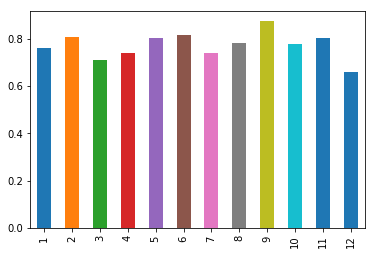

In [27]:
pd.Series(scores).sort_index().plot.bar();

### Make Predictions

In [38]:
predictions = pd.DataFrame({month: data.squeeze() for month, data in preds.items()}, index = range(preds[1].shape[0])).sort_index(1)
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489 entries, 0 to 2488
Data columns (total 12 columns):
1     2489 non-null float32
2     2489 non-null float32
3     2489 non-null float32
4     2489 non-null float32
5     2489 non-null float32
6     2489 non-null float32
7     2489 non-null float32
8     2489 non-null float32
9     2489 non-null float32
10    2489 non-null float32
11    2489 non-null float32
12    2489 non-null float32
dtypes: float32(12)
memory usage: 116.8 KB


### Evaluate Results

In [123]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

In [125]:
bins = np.arange(0, 1.01, .01)
roc, prc = pd.Series(), pd.Series()
avg_roc, avg_precision = [], []
for month, y_score in predictions.items():
    y_true = label[f'2017{month:02}01']
    avg_roc.append(roc_auc_score(y_true=y_true, y_score=y_score))
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    df.fpr = pd.cut(df.fpr, bins=bins, labels=bins[1:])
    roc = pd.concat([roc, df.groupby('fpr').tpr.mean().bfill().to_frame('tpr').reset_index()])
    
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    avg_precision.append(average_precision_score(y_true=y_true, y_score=y_score))
    df = pd.DataFrame({'precision': precision, 'recall': recall})
    df.recall = pd.cut(df.recall, bins=bins, labels=bins[1:])
    prc = pd.concat([prc, df.groupby('recall').precision.mean().ffill().to_frame('precision').reset_index()])
    

In [126]:
np.mean(avg_roc), np.mean(avg_precision)

(0.773903996249194, 0.6880594179772762)

To obtain a measure of the model’s generalization error, we evaluate its predictive performance on the hold-out set. To this end, we iteratively predict one month in the test after training the best-performing architecture on all preceding months.

The below ROC and Precision-Recall curves summarize the out-of-sample performance over the 12 months in 2017. The average AUC score is 0.7739, and the average precision is 68.8%, with the full range of the tradeoffs represented by the two graphs.

While the AUC scores underline solid predictive performance, we need to be careful because binary price moves ignore the size of the moves. We would need to deepen our analysis to understand whether good directional predictions would translate into a profitable trading strategy.

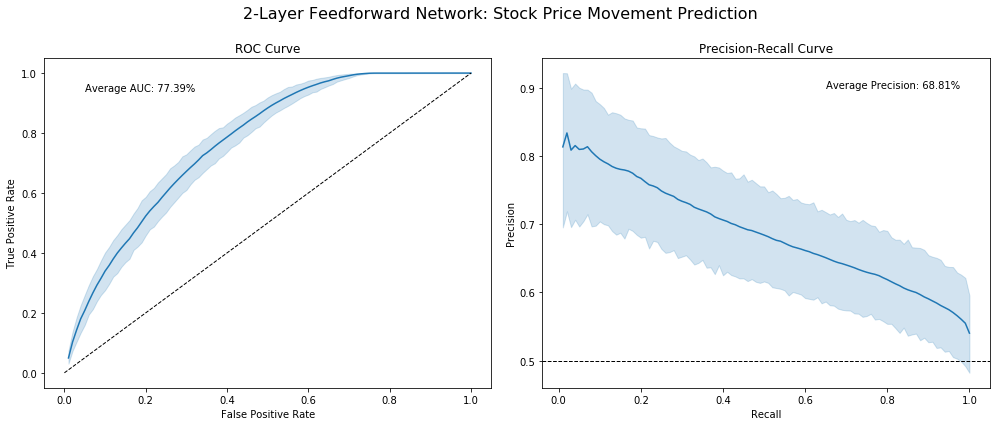

In [129]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.lineplot(x='fpr', y='tpr', data=roc, ax=axes[0])
pd.Series(bins, index=bins).plot(ax=axes[0], ls='--', lw=1, c='k')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].text(x=.05, y=.94, s=f'Average AUC: {np.mean(avg_roc):.2%}')
sns.lineplot(x='recall', y='precision', data=prc, ax=axes[1])
axes[1].set_title('Precision-Recall Curve')
axes[1].text(x=.65, y=.9, s=f'Average Precision: {np.mean(avg_precision):.2%}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].axhline(.5, ls='--', lw=1, c='k')
fig.suptitle('2-Layer Feedforward Network: Stock Price Movement Prediction', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.86)
fig.savefig('figures/roc_prc_curves', dpi=300);

### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
